In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_cont1R200.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]

In [5]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [6]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #print(IndexT_[0], IndexT_[int(IndexT_.size/2)], IndexT_[-1])
    
    #now lets cut at  a certain distance
    distance = 600 # distance in ckpc
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
  
    # ok, lets see the current status
    # the code: 0, completely free, 1 ICM, 2 in the central, 3 in other galaxy of the cluster, 4 in other galaxy or group.
    Status = np.zeros(IndexT_near.size)
    
    Thegroup = sim['SnapNumber_128/SubGroups/GroupNumber'][fofID]
    gro = sim['SnapNumber_128/SubGroups/GroupNumber'][centralID]
    
    PartGroup = sim['SnapNumber_128/PartType0/GroupNumber'][IndexT_near]
    PartSubGroup = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
    free = np.where((PartGroup == -1) & (PartSubGroup ==-1))
    ICM = np.where((PartGroup == Thegroup) & (PartSubGroup ==-1))
    centralGal = np.where(PartSubGroup == 0)
    otherGal = np.where((PartGroup == Thegroup) & (PartSubGroup > 0))
    otherGroup = np.where((PartGroup != Thegroup) & (PartGroup != -1))
    
    Status[free] = 0
    Status[ICM] = 1
    Status[centralGal] = 2
    Status[otherGal] = 3
    Status[otherGroup] = 4
    
    return IndexT_near, Status

In [7]:
# ok, lets try if this works before apply some serialized use.
Index, status = getAllLastP(4338, 4337)
print(status.size)

[95917 97421]
22302


([<matplotlib.axis.XTick at 0x7f1dd8db8be0>,
 <a list of 5 Text xticklabel objects>)

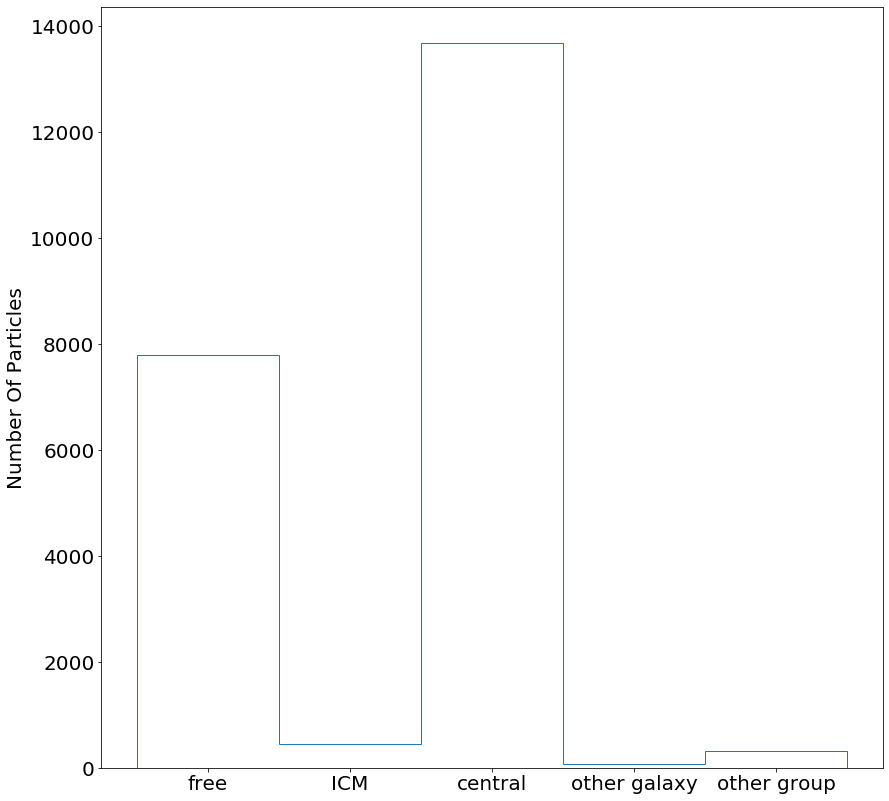

In [8]:
mark = ','
pl.figure(figsize=(14, 14))

bins = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
pl.hist(status, bins=bins, histtype='step')

pl.ylabel('Number Of Particles')
pl.xticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))

[98292 98732]


([<matplotlib.axis.XTick at 0x7f1dd8d58340>,
 <a list of 5 Text xticklabel objects>)

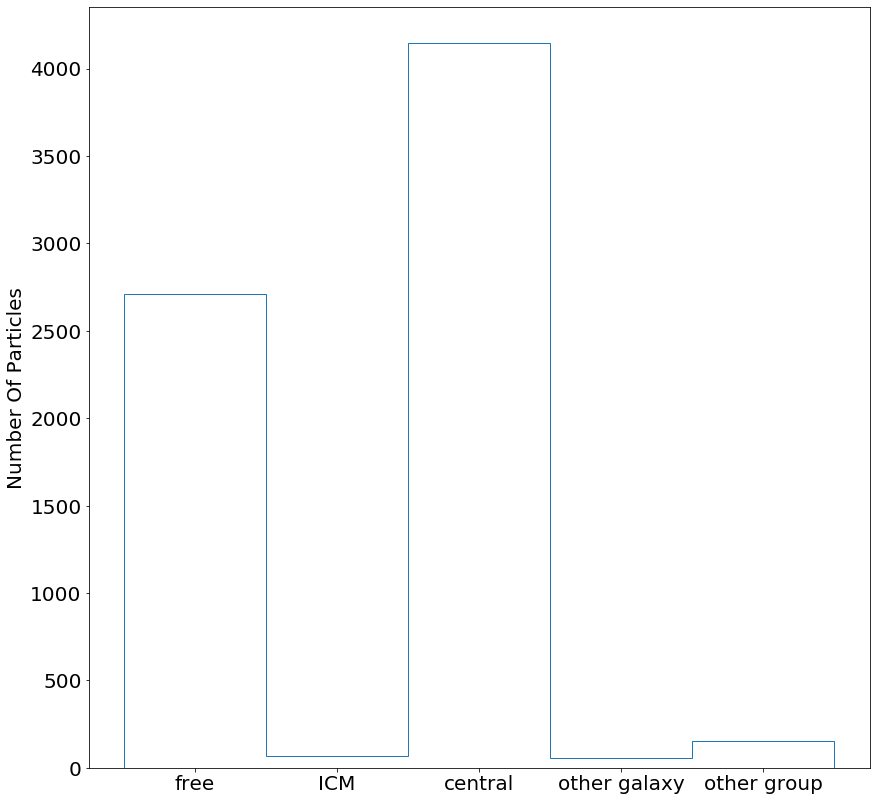

In [9]:
Index, status = getAllLastP(4341, 4337)

pl.figure(figsize=(14, 14))

bins = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
pl.hist(status, bins=bins, histtype='step')

pl.ylabel('Number Of Particles')
pl.xticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))

[193399 229080]


([<matplotlib.axis.XTick at 0x7f1dd7f19820>,
 <a list of 5 Text xticklabel objects>)

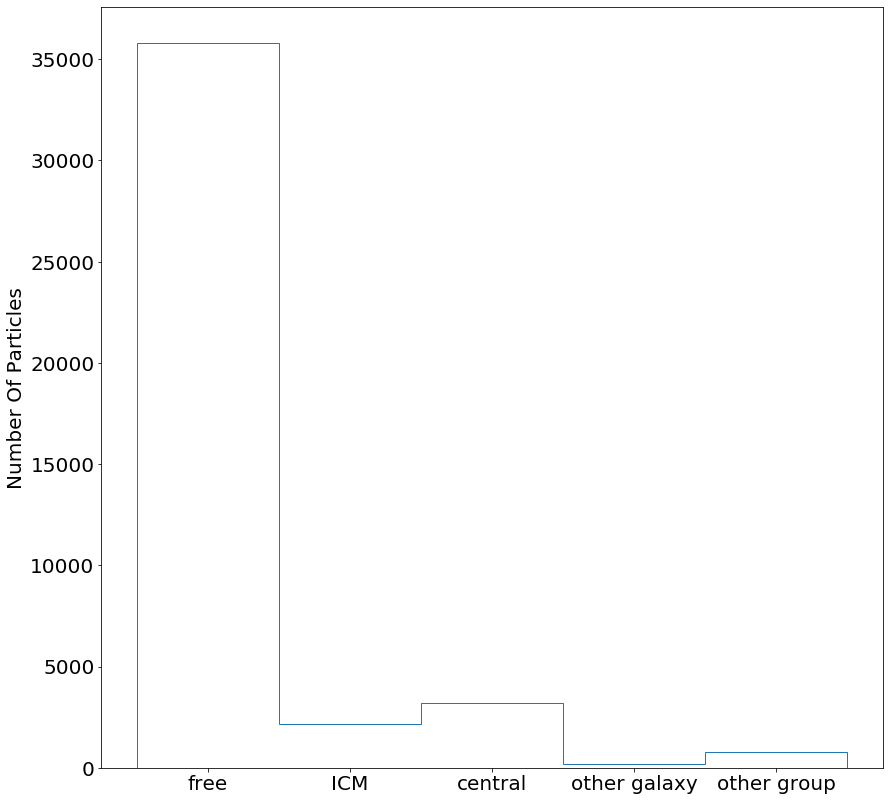

In [10]:
Index, status = getAllLastP(4470, 4469)

pl.figure(figsize=(14, 14))

bins = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
pl.hist(status, bins=bins, histtype='step')

pl.ylabel('Number Of Particles')
pl.xticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))

[254002 261427]


([<matplotlib.axis.XTick at 0x7f1dd8ae8b20>,
 <a list of 5 Text xticklabel objects>)

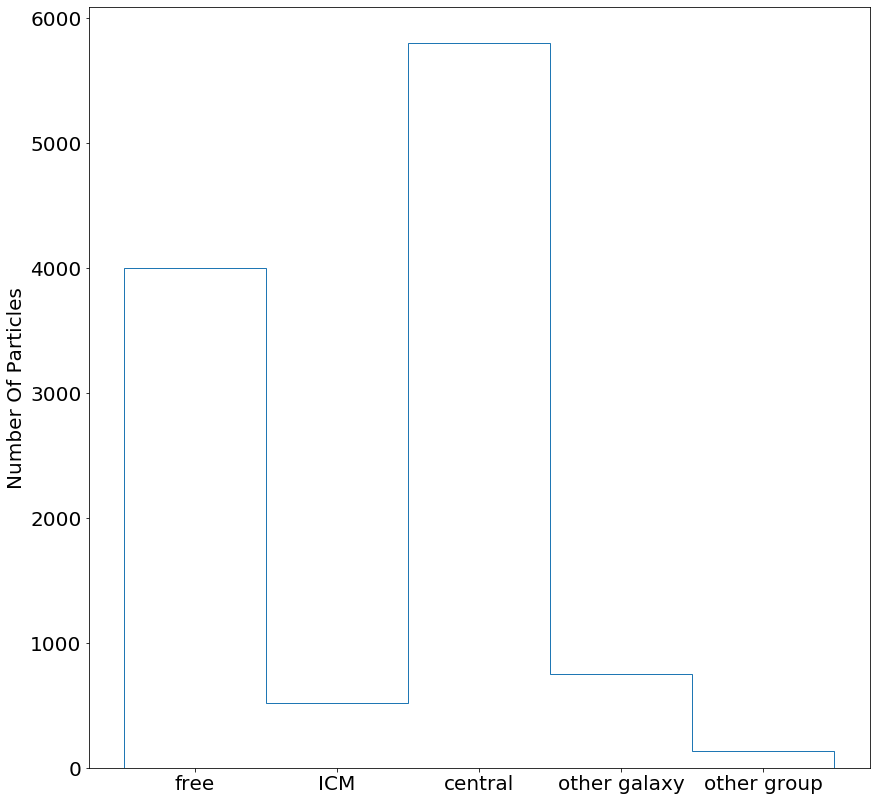

In [11]:
Index, status = getAllLastP(4474, 4469)

pl.figure(figsize=(14, 14))

bins = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
pl.hist(status, bins=bins, histtype='step')

pl.ylabel('Number Of Particles')
pl.xticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))

In [12]:
bar = progressbar.ProgressBar(max_value=Satellites.size)
C = 0

STATUS = []

for sa, ce in zip(Satellites, Centrals):
    Index, status = getAllLastP(sa, ce)
    STATUS.extend(list(status))
    C += 1
    bar.update(C)
    
STATUS = np.array(STATUS)

[771955 772362]


N/A% (0 of 515) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[-9223372036854775808 -9223372036854775808]


  0% (2 of 515) |                        | Elapsed Time: 0:00:03 ETA:   0:16:59

[-9223372036854775808 -9223372036854775808]


  0% (3 of 515) |                        | Elapsed Time: 0:00:04 ETA:   0:13:36

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


  1% (7 of 515) |                        | Elapsed Time: 0:00:05 ETA:   0:06:45

[835368 835497]


  1% (10 of 515) |                       | Elapsed Time: 0:00:10 ETA:   0:12:41

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


  2% (11 of 515) |                       | Elapsed Time: 0:00:10 ETA:   0:10:29

[-9223372036854775808 -9223372036854775808]


  2% (12 of 515) |                       | Elapsed Time: 0:00:14 ETA:   0:30:21

[870024 870025]
[-9223372036854775808 -9223372036854775808]


  3% (16 of 515) |                       | Elapsed Time: 0:00:17 ETA:   0:07:47

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]

  3% (17 of 515) |                       | Elapsed Time: 0:00:18 ETA:   0:06:23


[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


  3% (20 of 515) |                       | Elapsed Time: 0:00:19 ETA:   0:05:19

[-9223372036854775808 -9223372036854775808]
[882027 882029]


  4% (23 of 515) |#                      | Elapsed Time: 0:00:20 ETA:   0:03:11

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


  4% (25 of 515) |#                      | Elapsed Time: 0:00:21 ETA:   0:03:04

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


  6% (32 of 515) |#                      | Elapsed Time: 0:00:21 ETA:   0:01:29

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


  7% (40 of 515) |#                      | Elapsed Time: 0:00:22 ETA:   0:01:17

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


  8% (42 of 515) |#                      | Elapsed Time: 0:00:23 ETA:   0:01:06

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


  9% (48 of 515) |##                     | Elapsed Time: 0:00:23 ETA:   0:01:04

[-9223372036854775808 -9223372036854775808]
[938690 938692]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 10% (53 of 515) |##                     | Elapsed Time: 0:00:24 ETA:   0:00:58

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 11% (58 of 515) |##                     | Elapsed Time: 0:00:24 ETA:   0:00:49

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 12% (66 of 515) |##                     | Elapsed Time: 0:00:25 ETA:   0:00:49

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 13% (72 of 515) |###                    | Elapsed Time: 0:00:25 ETA:   0:00:42

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 14% (77 of 515) |###                    | Elapsed Time: 0:00:25 ETA:   0:00:25

[951470 951471]
[709335 709606]


 15% (78 of 515) |###                    | Elapsed Time: 0:00:29 ETA:   0:31:00

[-9223372036854775808 -9223372036854775808]


 15% (80 of 515) |###                    | Elapsed Time: 0:00:30 ETA:   0:12:20

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 15% (81 of 515) |###                    | Elapsed Time: 0:00:31 ETA:   0:10:54

[835170 835171]


 15% (82 of 515) |###                    | Elapsed Time: 0:00:32 ETA:   0:04:43

[-9223372036854775808 -9223372036854775808]
[852465 852628]


 16% (84 of 515) |###                    | Elapsed Time: 0:00:37 ETA:   0:17:15

[853803 853972]


 16% (87 of 515) |###                    | Elapsed Time: 0:00:41 ETA:   0:10:57

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 17% (90 of 515) |####                   | Elapsed Time: 0:00:42 ETA:   0:05:50

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 18% (95 of 515) |####                   | Elapsed Time: 0:00:46 ETA:   0:05:42

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 19% (98 of 515) |####                   | Elapsed Time: 0:00:47 ETA:   0:04:27

[-9223372036854775808 -9223372036854775808]


 19% (101 of 515) |####                  | Elapsed Time: 0:00:48 ETA:   0:02:53

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[920770 920784]


 20% (104 of 515) |####                  | Elapsed Time: 0:00:52 ETA:   0:09:34

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 20% (108 of 515) |####                  | Elapsed Time: 0:00:52 ETA:   0:04:11

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 21% (109 of 515) |####                  | Elapsed Time: 0:00:53 ETA:   0:04:15

[933264 933266]


 21% (113 of 515) |####                  | Elapsed Time: 0:00:57 ETA:   0:06:39

[-9223372036854775808 -9223372036854775808]
[935606 935607]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 22% (118 of 515) |#####                 | Elapsed Time: 0:00:58 ETA:   0:04:43

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 23% (122 of 515) |#####                 | Elapsed Time: 0:01:02 ETA:   0:03:52

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 24% (124 of 515) |#####                 | Elapsed Time: 0:01:02 ETA:   0:03:09

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 25% (130 of 515) |#####                 | Elapsed Time: 0:01:03 ETA:   0:02:10

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 26% (134 of 515) |#####                 | Elapsed Time: 0:01:03 ETA:   0:01:46

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 26% (139 of 515) |#####                 | Elapsed Time: 0:01:03 ETA:   0:01:26

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 27% (142 of 515) |######                | Elapsed Time: 0:01:03 ETA:   0:01:18

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 28% (148 of 515) |######                | Elapsed Time: 0:01:04 ETA:   0:00:29

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[95917 97421]


 29% (151 of 515) |######                | Elapsed Time: 0:02:58 ETA:   3:50:37

[97421 98292]


 29% (152 of 515) |######                | Elapsed Time: 0:03:18 ETA:   2:03:27

[-9223372036854775808 -9223372036854775808]


 29% (153 of 515) |######                | Elapsed Time: 0:03:35 ETA:   1:38:52

[98292 98732]


 29% (154 of 515) |######                | Elapsed Time: 0:03:50 ETA:   1:33:01

[-9223372036854775808 -9223372036854775808]


 30% (155 of 515) |######                | Elapsed Time: 0:06:29 ETA:  15:53:10

[-9223372036854775808 -9223372036854775808]


 30% (156 of 515) |######                | Elapsed Time: 0:06:53 ETA:   2:22:28

[-9223372036854775808 -9223372036854775808]


 30% (157 of 515) |######                | Elapsed Time: 0:06:57 ETA:   0:27:46

[-9223372036854775808 -9223372036854775808]


 30% (158 of 515) |######                | Elapsed Time: 0:07:02 ETA:   0:25:51

[-9223372036854775808 -9223372036854775808]


 30% (159 of 515) |######                | Elapsed Time: 0:07:06 ETA:   0:22:54

[-9223372036854775808 -9223372036854775808]


 31% (160 of 515) |######                | Elapsed Time: 0:07:10 ETA:   0:24:01

[-9223372036854775808 -9223372036854775808]


 31% (161 of 515) |######                | Elapsed Time: 0:07:14 ETA:   0:24:30

[-9223372036854775808 -9223372036854775808]


 31% (162 of 515) |######                | Elapsed Time: 0:07:18 ETA:   0:22:45

[-9223372036854775808 -9223372036854775808]


 31% (163 of 515) |######                | Elapsed Time: 0:07:21 ETA:   0:21:47

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 32% (165 of 515) |#######               | Elapsed Time: 0:07:25 ETA:   0:11:27

[-9223372036854775808 -9223372036854775808]


 32% (166 of 515) |#######               | Elapsed Time: 0:07:30 ETA:   0:26:40

[-9223372036854775808 -9223372036854775808]


 32% (167 of 515) |#######               | Elapsed Time: 0:07:34 ETA:   0:21:22

[-9223372036854775808 -9223372036854775808]


 32% (168 of 515) |#######               | Elapsed Time: 0:07:37 ETA:   0:21:51

[-9223372036854775808 -9223372036854775808]


 32% (169 of 515) |#######               | Elapsed Time: 0:07:43 ETA:   0:30:29

[-9223372036854775808 -9223372036854775808]


 33% (170 of 515) |#######               | Elapsed Time: 0:07:43 ETA:   0:16:27

[-9223372036854775808 -9223372036854775808]


 33% (171 of 515) |#######               | Elapsed Time: 0:07:47 ETA:   0:21:45

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 33% (173 of 515) |#######               | Elapsed Time: 0:07:51 ETA:   0:11:22

[-9223372036854775808 -9223372036854775808]


 33% (174 of 515) |#######               | Elapsed Time: 0:07:55 ETA:   0:21:55

[-9223372036854775808 -9223372036854775808]


 33% (175 of 515) |#######               | Elapsed Time: 0:07:58 ETA:   0:21:04

[-9223372036854775808 -9223372036854775808]


 34% (176 of 515) |#######               | Elapsed Time: 0:08:02 ETA:   0:20:58

[-9223372036854775808 -9223372036854775808]


 34% (177 of 515) |#######               | Elapsed Time: 0:08:06 ETA:   0:20:56

[-9223372036854775808 -9223372036854775808]


 34% (178 of 515) |#######               | Elapsed Time: 0:08:10 ETA:   0:21:04

[-9223372036854775808 -9223372036854775808]


 34% (179 of 515) |#######               | Elapsed Time: 0:08:13 ETA:   0:20:52

[-9223372036854775808 -9223372036854775808]


 34% (180 of 515) |#######               | Elapsed Time: 0:08:17 ETA:   0:21:28

[-9223372036854775808 -9223372036854775808]


 35% (181 of 515) |#######               | Elapsed Time: 0:08:21 ETA:   0:20:00

[-9223372036854775808 -9223372036854775808]


 35% (182 of 515) |#######               | Elapsed Time: 0:08:24 ETA:   0:19:07

[-9223372036854775808 -9223372036854775808]


 35% (183 of 515) |#######               | Elapsed Time: 0:08:28 ETA:   0:19:12

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 35% (185 of 515) |#######               | Elapsed Time: 0:08:29 ETA:   0:08:14

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 36% (187 of 515) |#######               | Elapsed Time: 0:08:29 ETA:   0:05:31

[-9223372036854775808 -9223372036854775808]


 36% (188 of 515) |########              | Elapsed Time: 0:08:33 ETA:   0:19:34

[-9223372036854775808 -9223372036854775808]


 36% (189 of 515) |########              | Elapsed Time: 0:08:36 ETA:   0:18:47

[-9223372036854775808 -9223372036854775808]


 36% (190 of 515) |########              | Elapsed Time: 0:08:40 ETA:   0:18:10

[-9223372036854775808 -9223372036854775808]


 37% (191 of 515) |########              | Elapsed Time: 0:08:43 ETA:   0:20:06

[-9223372036854775808 -9223372036854775808]


 37% (192 of 515) |########              | Elapsed Time: 0:08:47 ETA:   0:20:39

[-9223372036854775808 -9223372036854775808]


 37% (193 of 515) |########              | Elapsed Time: 0:08:51 ETA:   0:20:24

[-9223372036854775808 -9223372036854775808]


 37% (194 of 515) |########              | Elapsed Time: 0:08:55 ETA:   0:19:50

[-9223372036854775808 -9223372036854775808]


 37% (195 of 515) |########              | Elapsed Time: 0:08:58 ETA:   0:20:04

[-9223372036854775808 -9223372036854775808]


 38% (196 of 515) |########              | Elapsed Time: 0:09:02 ETA:   0:20:31

[-9223372036854775808 -9223372036854775808]


 38% (197 of 515) |########              | Elapsed Time: 0:09:06 ETA:   0:19:09

[-9223372036854775808 -9223372036854775808]


 38% (198 of 515) |########              | Elapsed Time: 0:09:10 ETA:   0:19:56

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 38% (200 of 515) |########              | Elapsed Time: 0:09:14 ETA:   0:10:21

[-9223372036854775808 -9223372036854775808]


 39% (201 of 515) |########              | Elapsed Time: 0:09:14 ETA:   0:08:16

[-9223372036854775808 -9223372036854775808]


 39% (203 of 515) |########              | Elapsed Time: 0:09:15 ETA:   0:07:06

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 39% (204 of 515) |########              | Elapsed Time: 0:09:16 ETA:   0:03:07

[-9223372036854775808 -9223372036854775808]


 39% (205 of 515) |########              | Elapsed Time: 0:09:17 ETA:   0:03:05

[-9223372036854775808 -9223372036854775808]


 40% (206 of 515) |########              | Elapsed Time: 0:09:18 ETA:   0:03:00

[-9223372036854775808 -9223372036854775808]


 40% (209 of 515) |########              | Elapsed Time: 0:09:21 ETA:   0:06:31

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 40% (211 of 515) |#########             | Elapsed Time: 0:09:23 ETA:   0:05:16

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 41% (212 of 515) |#########             | Elapsed Time: 0:09:27 ETA:   0:19:21

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 41% (214 of 515) |#########             | Elapsed Time: 0:09:27 ETA:   0:06:56

[-9223372036854775808 -9223372036854775808]


 41% (215 of 515) |#########             | Elapsed Time: 0:09:28 ETA:   0:06:38

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 42% (218 of 515) |#########             | Elapsed Time: 0:09:32 ETA:   0:06:24

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 43% (222 of 515) |#########             | Elapsed Time: 0:09:36 ETA:   0:09:29

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 43% (224 of 515) |#########             | Elapsed Time: 0:09:36 ETA:   0:03:20

[-9223372036854775808 -9223372036854775808]


 43% (225 of 515) |#########             | Elapsed Time: 0:09:40 ETA:   0:18:26

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 44% (227 of 515) |#########             | Elapsed Time: 0:09:41 ETA:   0:07:20

[-9223372036854775808 -9223372036854775808]


 44% (228 of 515) |#########             | Elapsed Time: 0:09:42 ETA:   0:03:26

[-9223372036854775808 -9223372036854775808]


 44% (229 of 515) |#########             | Elapsed Time: 0:09:46 ETA:   0:18:02

[-9223372036854775808 -9223372036854775808]


 45% (232 of 515) |#########             | Elapsed Time: 0:09:46 ETA:   0:05:07

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 45% (236 of 515) |##########            | Elapsed Time: 0:09:47 ETA:   0:03:08

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 46% (239 of 515) |##########            | Elapsed Time: 0:09:48 ETA:   0:02:19

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 46% (240 of 515) |##########            | Elapsed Time: 0:09:49 ETA:   0:01:15

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 47% (243 of 515) |##########            | Elapsed Time: 0:09:52 ETA:   0:05:39

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 48% (248 of 515) |##########            | Elapsed Time: 0:09:54 ETA:   0:02:54

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 49% (254 of 515) |##########            | Elapsed Time: 0:09:54 ETA:   0:01:41

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 51% (264 of 515) |###########           | Elapsed Time: 0:09:54 ETA:   0:00:24

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 52% (268 of 515) |###########           | Elapsed Time: 0:09:55 ETA:   0:00:22

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 53% (278 of 515) |###########           | Elapsed Time: 0:09:55 ETA:   0:00:16

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 54% (280 of 515) |###########           | Elapsed Time: 0:09:56 ETA:   0:00:17

[-9223372036854775808 -9223372036854775808]
[193399 229080]


 54% (282 of 515) |############          | Elapsed Time: 0:18:12 ETA:  16:02:08

[229080 246041]


 54% (283 of 515) |########       | Elapsed Time: 0:43:45 ETA:  4 days, 2:48:22

[246041 250423]


 55% (284 of 515) |############          | Elapsed Time: 0:44:08 ETA:   1:28:36

[250423 254002]


 55% (285 of 515) |############          | Elapsed Time: 0:44:23 ETA:   1:00:15

[254002 261427]


 55% (286 of 515) |############          | Elapsed Time: 0:44:57 ETA:   2:06:28

[261427 261429]


 55% (287 of 515) |############          | Elapsed Time: 0:45:02 ETA:   0:19:53

[261429 261505]


 55% (288 of 515) |############          | Elapsed Time: 0:45:14 ETA:   0:46:44

[261505 261755]


 56% (289 of 515) |############          | Elapsed Time: 0:45:22 ETA:   0:28:15

[261755 262315]


 56% (290 of 515) |############          | Elapsed Time: 0:45:31 ETA:   0:36:38

[262315 262462]


 56% (291 of 515) |############          | Elapsed Time: 0:45:36 ETA:   0:16:21

[262462 262738]


 56% (292 of 515) |############          | Elapsed Time: 0:45:44 ETA:   0:30:27

[262738 262794]


 56% (293 of 515) |############          | Elapsed Time: 0:45:49 ETA:   0:17:02

[262794 263030]


 57% (294 of 515) |############          | Elapsed Time: 0:45:53 ETA:   0:16:05

[-9223372036854775808 -9223372036854775808]


 57% (295 of 515) |############          | Elapsed Time: 0:45:58 ETA:   0:19:22

[-9223372036854775808 -9223372036854775808]


 57% (296 of 515) |############          | Elapsed Time: 0:46:07 ETA:   0:30:31

[-9223372036854775808 -9223372036854775808]


 57% (297 of 515) |############          | Elapsed Time: 0:46:11 ETA:   0:15:33

[-9223372036854775808 -9223372036854775808]


 57% (298 of 515) |############          | Elapsed Time: 0:46:15 ETA:   0:13:49

[-9223372036854775808 -9223372036854775808]


 58% (299 of 515) |############          | Elapsed Time: 0:46:19 ETA:   0:14:06

[-9223372036854775808 -9223372036854775808]


 58% (300 of 515) |############          | Elapsed Time: 0:46:23 ETA:   0:13:54

[-9223372036854775808 -9223372036854775808]


 58% (301 of 515) |############          | Elapsed Time: 0:46:27 ETA:   0:15:01

[-9223372036854775808 -9223372036854775808]


 58% (302 of 515) |############          | Elapsed Time: 0:46:30 ETA:   0:12:20

[-9223372036854775808 -9223372036854775808]


 58% (303 of 515) |############          | Elapsed Time: 0:46:34 ETA:   0:13:44

[-9223372036854775808 -9223372036854775808]


 59% (305 of 515) |#############         | Elapsed Time: 0:46:38 ETA:   0:06:55

[-9223372036854775808 -9223372036854775808]


 59% (306 of 515) |#############         | Elapsed Time: 0:46:39 ETA:   0:05:22

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 59% (307 of 515) |#############         | Elapsed Time: 0:46:42 ETA:   0:12:10

[-9223372036854775808 -9223372036854775808]


 59% (308 of 515) |#############         | Elapsed Time: 0:46:46 ETA:   0:12:41

[-9223372036854775808 -9223372036854775808]


 60% (309 of 515) |#############         | Elapsed Time: 0:46:47 ETA:   0:08:02

[-9223372036854775808 -9223372036854775808]


 60% (310 of 515) |#############         | Elapsed Time: 0:46:48 ETA:   0:06:07

[-9223372036854775808 -9223372036854775808]


 60% (312 of 515) |#############         | Elapsed Time: 0:46:52 ETA:   0:06:50

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 60% (313 of 515) |#############         | Elapsed Time: 0:46:52 ETA:   0:05:23

[-9223372036854775808 -9223372036854775808]


 60% (314 of 515) |#############         | Elapsed Time: 0:46:56 ETA:   0:12:28

[-9223372036854775808 -9223372036854775808]


 61% (315 of 515) |#############         | Elapsed Time: 0:46:57 ETA:   0:07:02

[-9223372036854775808 -9223372036854775808]


 61% (317 of 515) |#############         | Elapsed Time: 0:46:58 ETA:   0:02:12

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 61% (318 of 515) |#############         | Elapsed Time: 0:47:02 ETA:   0:13:58

[-9223372036854775808 -9223372036854775808]


 61% (319 of 515) |#############         | Elapsed Time: 0:47:06 ETA:   0:12:26

[-9223372036854775808 -9223372036854775808]


 62% (320 of 515) |#############         | Elapsed Time: 0:47:10 ETA:   0:12:20

[-9223372036854775808 -9223372036854775808]


 62% (321 of 515) |#############         | Elapsed Time: 0:47:14 ETA:   0:13:14

[-9223372036854775808 -9223372036854775808]


 62% (322 of 515) |#############         | Elapsed Time: 0:47:18 ETA:   0:12:19

[-9223372036854775808 -9223372036854775808]


 62% (323 of 515) |#############         | Elapsed Time: 0:47:22 ETA:   0:12:11

[-9223372036854775808 -9223372036854775808]


 62% (324 of 515) |#############         | Elapsed Time: 0:47:26 ETA:   0:12:11

[-9223372036854775808 -9223372036854775808]


 63% (325 of 515) |#############         | Elapsed Time: 0:47:26 ETA:   0:07:23

[-9223372036854775808 -9223372036854775808]


 63% (326 of 515) |#############         | Elapsed Time: 0:47:27 ETA:   0:05:55

[-9223372036854775808 -9223372036854775808]


 63% (328 of 515) |##############        | Elapsed Time: 0:47:31 ETA:   0:06:17

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 63% (329 of 515) |##############        | Elapsed Time: 0:47:32 ETA:   0:04:33

[-9223372036854775808 -9223372036854775808]


 64% (330 of 515) |##############        | Elapsed Time: 0:47:33 ETA:   0:04:01

[-9223372036854775808 -9223372036854775808]


 64% (331 of 515) |##############        | Elapsed Time: 0:47:36 ETA:   0:11:27

[-9223372036854775808 -9223372036854775808]


 64% (333 of 515) |##############        | Elapsed Time: 0:47:40 ETA:   0:06:00

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 64% (334 of 515) |##############        | Elapsed Time: 0:47:44 ETA:   0:11:23

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 65% (337 of 515) |##############        | Elapsed Time: 0:47:45 ETA:   0:03:23

[-9223372036854775808 -9223372036854775808]


 65% (338 of 515) |##############        | Elapsed Time: 0:47:49 ETA:   0:11:22

[-9223372036854775808 -9223372036854775808]


 65% (339 of 515) |##############        | Elapsed Time: 0:47:50 ETA:   0:06:56

[-9223372036854775808 -9223372036854775808]


 66% (340 of 515) |##############        | Elapsed Time: 0:47:50 ETA:   0:05:00

[-9223372036854775808 -9223372036854775808]


 66% (341 of 515) |##############        | Elapsed Time: 0:47:54 ETA:   0:11:18

[-9223372036854775808 -9223372036854775808]


 66% (342 of 515) |##############        | Elapsed Time: 0:47:55 ETA:   0:06:35

[-9223372036854775808 -9223372036854775808]


 66% (343 of 515) |##############        | Elapsed Time: 0:47:55 ETA:   0:05:10

[-9223372036854775808 -9223372036854775808]


 66% (344 of 515) |##############        | Elapsed Time: 0:47:57 ETA:   0:03:17

[-9223372036854775808 -9223372036854775808]


 66% (345 of 515) |##############        | Elapsed Time: 0:47:58 ETA:   0:03:45

[-9223372036854775808 -9223372036854775808]


 67% (346 of 515) |##############        | Elapsed Time: 0:47:59 ETA:   0:02:52

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 67% (350 of 515) |##############        | Elapsed Time: 0:47:59 ETA:   0:01:08

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 68% (351 of 515) |##############        | Elapsed Time: 0:48:03 ETA:   0:10:17

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 68% (352 of 515) |###############       | Elapsed Time: 0:48:05 ETA:   0:07:00

[-9223372036854775808 -9223372036854775808]


 68% (353 of 515) |###############       | Elapsed Time: 0:48:06 ETA:   0:03:06

[-9223372036854775808 -9223372036854775808]


 68% (354 of 515) |###############       | Elapsed Time: 0:48:09 ETA:   0:10:05

[-9223372036854775808 -9223372036854775808]


 68% (355 of 515) |###############       | Elapsed Time: 0:48:10 ETA:   0:06:04

[-9223372036854775808 -9223372036854775808]


 69% (357 of 515) |###############       | Elapsed Time: 0:48:11 ETA:   0:03:47

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 69% (358 of 515) |###############       | Elapsed Time: 0:48:12 ETA:   0:01:45

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 70% (362 of 515) |###############       | Elapsed Time: 0:48:13 ETA:   0:00:55

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 70% (363 of 515) |###############       | Elapsed Time: 0:48:13 ETA:   0:00:50

[-9223372036854775808 -9223372036854775808]


 71% (367 of 515) |###############       | Elapsed Time: 0:48:14 ETA:   0:00:38

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 71% (370 of 515) |###############       | Elapsed Time: 0:48:18 ETA:   0:03:10

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 72% (373 of 515) |###############       | Elapsed Time: 0:48:19 ETA:   0:01:46

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 73% (376 of 515) |################      | Elapsed Time: 0:48:19 ETA:   0:01:13

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 73% (378 of 515) |################      | Elapsed Time: 0:48:19 ETA:   0:01:00

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 73% (379 of 515) |################      | Elapsed Time: 0:48:23 ETA:   0:08:29

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 73% (381 of 515) |################      | Elapsed Time: 0:48:24 ETA:   0:03:45

[-9223372036854775808 -9223372036854775808]


 74% (384 of 515) |################      | Elapsed Time: 0:48:28 ETA:   0:02:55

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 75% (388 of 515) |################      | Elapsed Time: 0:48:29 ETA:   0:01:20

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 75% (389 of 515) |################      | Elapsed Time: 0:48:33 ETA:   0:08:02

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 76% (395 of 515) |################      | Elapsed Time: 0:48:37 ETA:   0:01:18

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 77% (398 of 515) |#################     | Elapsed Time: 0:48:40 ETA:   0:02:32

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 78% (403 of 515) |#################     | Elapsed Time: 0:48:41 ETA:   0:00:58

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 79% (407 of 515) |#################     | Elapsed Time: 0:48:41 ETA:   0:00:39

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 79% (411 of 515) |#################     | Elapsed Time: 0:48:41 ETA:   0:00:30

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 80% (415 of 515) |#################     | Elapsed Time: 0:48:42 ETA:   0:00:26

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 81% (421 of 515) |#################     | Elapsed Time: 0:48:42 ETA:   0:00:20

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 82% (426 of 515) |##################    | Elapsed Time: 0:48:42 ETA:   0:00:06

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 84% (437 of 515) |##################    | Elapsed Time: 0:48:43 ETA:   0:00:04

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 85% (440 of 515) |##################    | Elapsed Time: 0:48:44 ETA:   0:00:06

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 85% (442 of 515) |##################    | Elapsed Time: 0:48:45 ETA:   0:00:09

[797578 798091]


 86% (443 of 515) |##################    | Elapsed Time: 0:48:49 ETA:   0:05:00

[-9223372036854775808 -9223372036854775808]


 86% (446 of 515) |###################   | Elapsed Time: 0:48:50 ETA:   0:01:35

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[827962 828350]


 86% (447 of 515) |###################   | Elapsed Time: 0:48:55 ETA:   0:05:47

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 87% (450 of 515) |###################   | Elapsed Time: 0:48:59 ETA:   0:01:23

[-9223372036854775808 -9223372036854775808]


 87% (451 of 515) |###################   | Elapsed Time: 0:49:00 ETA:   0:01:15

[-9223372036854775808 -9223372036854775808]


 87% (452 of 515) |###################   | Elapsed Time: 0:49:01 ETA:   0:01:11

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[857059 857286]


 88% (456 of 515) |###################   | Elapsed Time: 0:49:05 ETA:   0:01:07

[861342 861344]
[861344 861345]


 89% (459 of 515) |###################   | Elapsed Time: 0:49:07 ETA:   0:00:45

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 89% (460 of 515) |###################   | Elapsed Time: 0:49:07 ETA:   0:00:22

[-9223372036854775808 -9223372036854775808]


 89% (461 of 515) |###################   | Elapsed Time: 0:49:11 ETA:   0:03:24

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 90% (464 of 515) |###################   | Elapsed Time: 0:49:12 ETA:   0:00:58

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 90% (466 of 515) |###################   | Elapsed Time: 0:49:12 ETA:   0:00:42

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 91% (469 of 515) |####################  | Elapsed Time: 0:49:13 ETA:   0:00:12

[-9223372036854775808 -9223372036854775808]


 91% (470 of 515) |####################  | Elapsed Time: 0:49:14 ETA:   0:00:15

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 92% (475 of 515) |####################  | Elapsed Time: 0:49:15 ETA:   0:00:10

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 92% (476 of 515) |####################  | Elapsed Time: 0:49:15 ETA:   0:00:12

[-9223372036854775808 -9223372036854775808]
[901323 901326]


 93% (479 of 515) |####################  | Elapsed Time: 0:49:18 ETA:   0:00:35

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[907128 907134]


 93% (483 of 515) |####################  | Elapsed Time: 0:49:22 ETA:   0:00:31

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]

 93% (484 of 515) |####################  | Elapsed Time: 0:49:23 ETA:   0:00:25


[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 94% (486 of 515) |####################  | Elapsed Time: 0:49:26 ETA:   0:00:56

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 94% (489 of 515) |####################  | Elapsed Time: 0:49:30 ETA:   0:00:34

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 95% (493 of 515) |##################### | Elapsed Time: 0:49:31 ETA:   0:00:14

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 96% (496 of 515) |##################### | Elapsed Time: 0:49:31 ETA:   0:00:09

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 97% (502 of 515) |##################### | Elapsed Time: 0:49:32 ETA:   0:00:04

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


 99% (511 of 515) |##################### | Elapsed Time: 0:49:32 ETA:   0:00:00

[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808]


([<matplotlib.axis.XTick at 0x7f1dd7b5b670>,
 <a list of 5 Text xticklabel objects>)

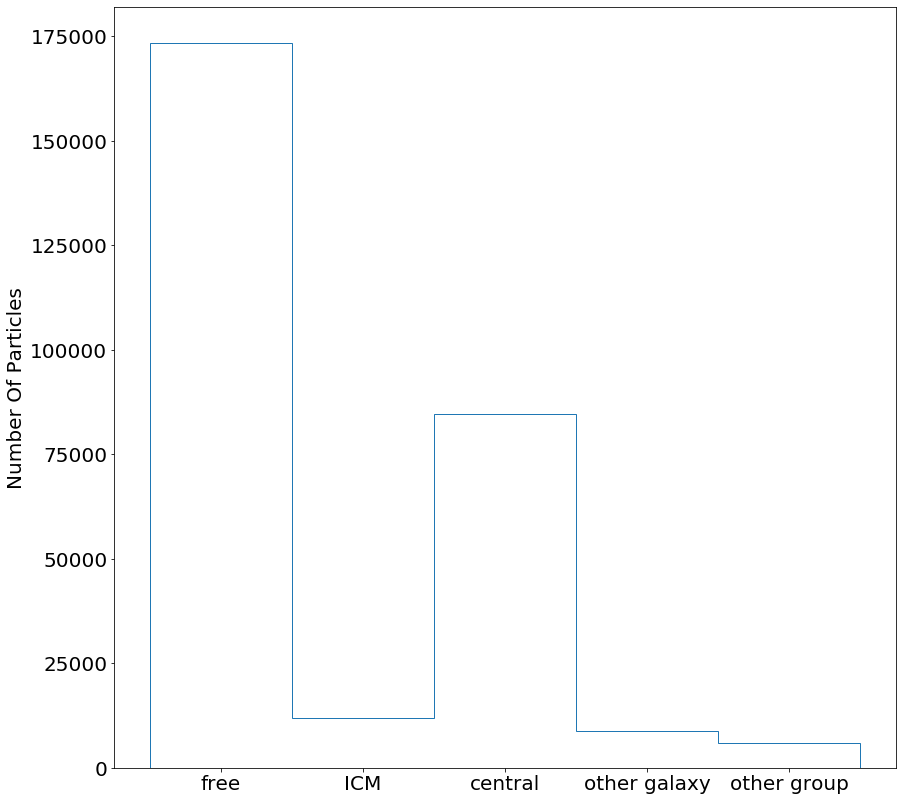

In [13]:
pl.figure(figsize=(14, 14))

bins = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
pl.hist(STATUS, bins=bins, histtype='step')

pl.ylabel('Number Of Particles')
pl.xticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))